In [31]:
import os

import pandas as pd
import numpy as np
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')


import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [32]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [33]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

In [42]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('수출금액_최종.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
#data.dtypes

#data.dtypes --> float type 확인
data['한국수출금액_USD'] = (data['한국수출금액_USD'].str.split()).apply(lambda x: float(x[0].replace(',', '')))


data.head()

(264, 22)


,한국수출금액_USD,한국수입금액_USD,경기종합지수,수출물가지수,수입물가지수,화물수송총괄,코스피지수,코스닥지수,환율,Dubai,다우존스지수,나스닥지수,한국소비자물가지수,미국생산자물가지수,전산업생산지수,실업률,부산항수출금액_1000달러,부산항수입금액_1000달러,반도체수출금액현황,수출물가등락률,수출단가지수,무역경기확산지수
Date,,,,,,,,,,,,,,,,,,,,,,
2000-01-31,1.216242e+10,12594622951,58.5,133.7,75.5,"181,367",943.88,"1,903.70","1,131.07",23.43,10940.53,3940.35,62.456,71.05,55.0,5.7,"5,140,310","3,605,241",1826335925,2.9,124.5,61.1
2000-02-29,1.267604e+10,12023652340,58.7,130.6,75.9,"218,300",828.38,"2,663.70","1,128.80",24.72,10128.31,4696.69,62.647,71.88,51.9,5.7,"4,984,788","3,321,729",1711340573,2.0,124.1,53.3
2000-03-31,1.442970e+10,14212010950,59.0,129.6,76.7,"206,116",860.94,"2,212.70","1,117.19",25.05,10921.92,4572.83,62.962,72.43,58.7,5.1,"6,047,778","4,080,972",1885848589,-3.3,122.9,66.7
2000-04-30,1.352204e+10,13344532361,58.8,129.1,75.2,"166,931",725.39,"1,581.80","1,109.76",22.19,10733.91,3860.66,62.709,72.38,56.9,4.5,"5,593,812","3,823,350",1901689230,-4.3,123.3,61.9
2000-05-31,1.463675e+10,13283355868,58.8,129.0,76.1,"208,853",731.88,"1,441.50","1,120.01",25.81,10522.33,3400.91,62.393,72.88,59.6,4.1,"5,914,069","3,908,017",2175250583,-1.5,121.9,64.1


### 1. SARIMA

In [43]:
train_data = data['한국수출금액_USD']

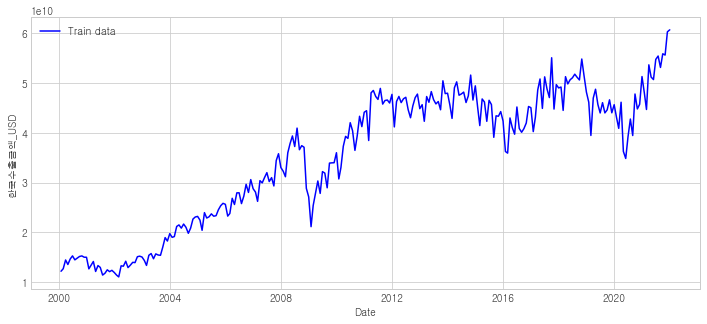

In [44]:
plt.figure(figsize=(12,5))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('한국수출금액_USD')
plt.plot(data['한국수출금액_USD'], 'blue', label='Train data')
plt.legend()

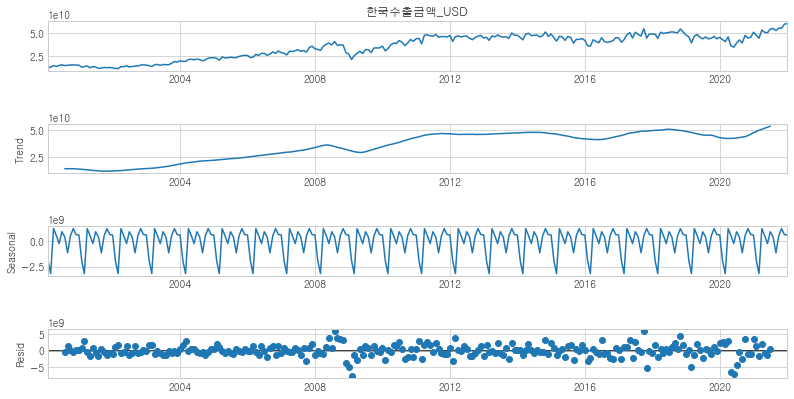

In [45]:
decomposition = sm.tsa.seasonal_decompose(data['한국수출금액_USD'],model='additive',period=12)
fig = decomposition.plot()
fig.set_size_inches(12,6)
plt.show()

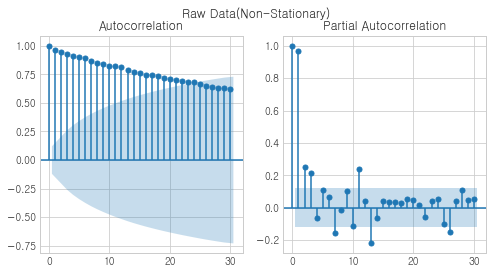

In [46]:
# ACF, PACF 
fig,ax = plt.subplots(1,2,figsize=(8,4))
fig.suptitle('Raw Data(Non-Stationary)')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(),lags=30,ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(),lags=30,ax=ax[1]);

In [47]:
# 정상성 검정 
# H0: 비정상 시계열 / H1: 정상 시계열
adfuller_test = adfuller(train_data, autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1])) # --> H0 기각 못하는 비정상 시계열에 대한 통계적 증명 

ADF test statistic: -0.9661879970974566
p-value: 0.7653958819308659


In [48]:
# 차분 --> 정상 시계열로 변환
diff_train_data = train_data.copy()
diff_train_data = diff_train_data.diff()
diff_train_data = diff_train_data.dropna() # 차분 결과 생성된 결측값 제거 

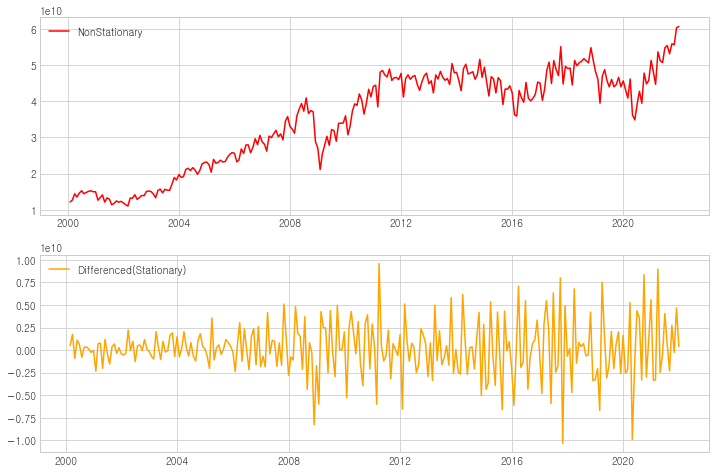

In [49]:
# 차분 이후 정상 시계열 
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data,'red')
plt.legend(['NonStationary'])
plt.subplot(212)
plt.plot(diff_train_data,'orange')
plt.legend(['Differenced(Stationary)'])
plt.show()

In [50]:
# 차분 진행 이후 ADF 검정 
adfuller_test = adfuller(diff_train_data, autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1])) # --> H0 기각. 정상 시계열 

ADF test statistic: -3.6669121721199476
p-value: 0.004603382380896192


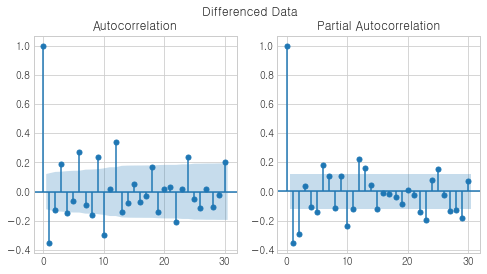

In [51]:
# 차분 이후ACF, PACF. --> ARIMA(p,d,q) 모수 직접 선별 까다로움 
fig,ax = plt.subplots(1,2,figsize=(8,4))
fig.suptitle('Differenced Data')

sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(),lags=30,ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(),lags=30,ax=ax[1]);

#### Auto ARIMA

In [52]:
auto_arima_model = auto_arima(train_data,start_p=1,start_q=1,
                             max_p=3,max_q=3,m=12,seasonal=True,
                             d=1,D=1,
                             max_P=3,max_Q=3,
                             trace=False,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True) # stepwise = True 

In [53]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  264
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -5794.204
Date:                              Thu, 30 Jun 2022   AIC                          11596.408
Time:                                      15:26:24   BIC                          11610.509
Sample:                                           0   HQIC                         11602.083
                                              - 264                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4500      0.078     -5.750      0.000      -0.603      -0.297
ar.L2         -0.1100      0.091     -1.215      0.224      -0.287       0.067
ma.S.L12      -0.7703      0.074    -10.362      0.000      -0.916      -0.625
sigma2      9.457e+18   2.01e-21    4.7e+39      0.000    9.46e+18    9.46e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                90.60
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               4.88   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+55. Standard errors may be unstable.
"""

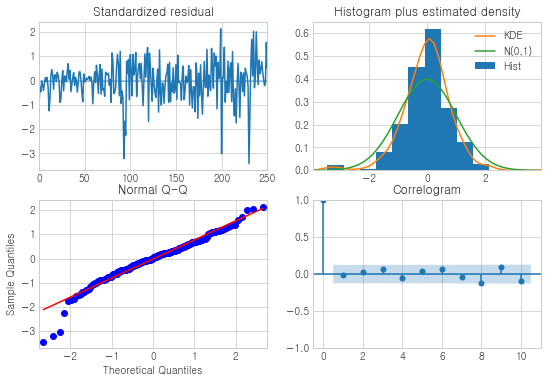

In [54]:
auto_arima_model.plot_diagnostics(figsize=(9,6))
plt.show()

In [55]:
auto_arima_model.fit(train_data)

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [56]:
future_forecast = auto_arima_model.predict(n_periods=6)
future_forecast

array([5.76693461e+10, 5.52109055e+10, 6.17695846e+10, 5.96180534e+10,
       5.81349878e+10, 6.07412086e+10])

#### ARIMA 수동

In [57]:
import warnings 
warnings.filterwarnings(action='ignore')

In [74]:
model = SARIMAX(train_data,order=(0, 1, 0), seasonal_order=(0, 1, 0, 12),suppress_warnings=True, with_intercept=False)
results = model.fit()

In [75]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         한국수출금액_USD   No. Observations:                  264
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -5869.410
Date:                            Thu, 30 Jun 2022   AIC                          11740.819
Time:                                    15:28:07   BIC                          11744.344
Sample:                                01-31-2000   HQIC                         11742.238
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.138e+19   6.74e+17     16.887      0.000    1.01e+19    1.27e+19
===================================================================================
Ljung-Box (L1) (Q):                  51.65   Jarque-Bera (JB):                46.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.21   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
from pandas.tseries.offsets import DateOffset

In [77]:
future_dates = [data.index[-1] + DateOffset(months=x) for x in range(0,7) ] # 향후 예측 기간 설정
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=data.columns)
future_df = pd.concat([data,future_dates_df])
len(data),len(future_df),len(future_dates_df)

(264, 270, 6)

In [78]:
future_df['forecast'] = results.predict(start = 264, end = 270, dynamic= True) 
future_df['forecast'].tail(6)

2022-01-31    5.740864e+10
2022-02-28    5.410857e+10
2022-03-31    6.309258e+10
2022-04-30    6.062766e+10
2022-05-31    6.012683e+10
2022-06-30    6.418057e+10
Name: forecast, dtype: float64